# Imports

In [1]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_file = 'data/continuous_dataset.csv'
df = pd.read_csv(data_file)

data_file = 'data/weekly_pre_dispatch_forecast.csv'
df_forecast_pre_dispatch = pd.read_csv(data_file)

In [3]:
# This dataset contains the feature variables and dependent variable datetime.
df

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48043,2020-06-26 20:00:00,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,23.746545,0.018381,0.150879,2.444658,0,0,1
48044,2020-06-26 21:00:00,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,23.693323,0.018320,0.156311,2.515814,0,0,1
48045,2020-06-26 22:00:00,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,23.658655,0.018327,0.153259,2.800717,0,0,1
48046,2020-06-26 23:00:00,1041.6240,26.867487,0.020464,0.064178,10.326567,25.258112,0.019403,0.108063,2.720871,23.601862,0.018358,0.152771,3.138132,0,0,1


In [4]:
# Load forecast in the pre dispatch reports is the prediction made by the grid operator.
# This is not a feature for our model but could be compared with our predictions as an exploratory activity.
df_forecast_pre_dispatch

,datetime,load_forecast
0,1/2/2016 0:00,1056.9
1,1/2/2016 1:00,1057.1
2,1/2/2016 2:00,996.5
3,1/2/2016 3:00,955.8
4,1/2/2016 4:00,918.0
...,...,...
40147,7/31/2020 19:00,1181.4
40148,7/31/2020 20:00,1196.8
40149,7/31/2020 21:00,1163.3
40150,7/31/2020 22:00,1136.0


In [5]:
df.describe()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
count,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000
mean,1182.868647,27.399111,0.018313,0.079979,13.391049,26.921023,0.017844,0.106265,7.046675,24.719513,0.016867,0.144681,3.567589,0.704795,0.062937,0.727793
std,192.068896,1.675462,0.001607,0.065589,7.295502,3.018129,0.001889,0.086293,4.103711,2.414019,0.001584,0.087899,1.710522,3.147470,0.242852,0.445100
min,85.192500,22.953455,0.012054,0.000000,0.008979,19.765222,0.010247,0.000009,0.060394,19.933740,0.009655,0.000032,0.015497,0.000000,0.000000,0.000000
25%,1020.056900,26.160455,0.017236,0.026451,7.544958,24.769281,0.016584,0.036819,3.955051,22.954652,0.015800,0.075775,2.298887,0.000000,0.000000,0.000000
50%,1168.427700,27.118051,0.018590,0.065201,12.182103,26.167352,0.018351,0.085968,5.992762,24.001718,0.017167,0.130188,3.413994,0.000000,0.000000,1.000000
75%,1327.563950,28.558344,0.019521,0.117310,18.661282,28.712335,0.019242,0.157288,9.409871,26.243402,0.018067,0.200012,4.670628,0.000000,0.000000,1.000000
max,1754.882000,35.039575,0.022690,0.521240,39.229726,39.063440,0.022165,0.484985,24.483937,34.216211,0.021066,0.477783,10.288902,22.000000,1.000000,1.000000


In [6]:
# Checking if there are missing values. None found.
df.isna().sum()

datetime      0
nat_demand    0
T2M_toc       0
QV2M_toc      0
TQL_toc       0
W2M_toc       0
T2M_san       0
QV2M_san      0
TQL_san       0
W2M_san       0
T2M_dav       0
QV2M_dav      0
TQL_dav       0
W2M_dav       0
Holiday_ID    0
holiday       0
school        0
dtype: int64

In [7]:
# Making columns lower case for better readability.
df.columns = df.columns.str.lower()
df

,datetime,nat_demand,t2m_toc,qv2m_toc,tql_toc,w2m_toc,t2m_san,qv2m_san,tql_san,w2m_san,t2m_dav,qv2m_dav,tql_dav,w2m_dav,holiday_id,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48043,2020-06-26 20:00:00,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,23.746545,0.018381,0.150879,2.444658,0,0,1
48044,2020-06-26 21:00:00,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,23.693323,0.018320,0.156311,2.515814,0,0,1
48045,2020-06-26 22:00:00,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,23.658655,0.018327,0.153259,2.800717,0,0,1
48046,2020-06-26 23:00:00,1041.6240,26.867487,0.020464,0.064178,10.326567,25.258112,0.019403,0.108063,2.720871,23.601862,0.018358,0.152771,3.138132,0,0,1


In [8]:
# Check the data types of the variables
df.dtypes

datetime       object
nat_demand    float64
t2m_toc       float64
qv2m_toc      float64
tql_toc       float64
w2m_toc       float64
t2m_san       float64
qv2m_san      float64
tql_san       float64
w2m_san       float64
t2m_dav       float64
qv2m_dav      float64
tql_dav       float64
w2m_dav       float64
holiday_id      int64
holiday         int64
school          int64
dtype: object

In [9]:
# Checking if variable `school` has non-boolean values
df.school.value_counts()

1    34969
0    13079
Name: school, dtype: int64

In [10]:
# Checking if variable `holiday` has non-boolean values
df.holiday.value_counts()

0    45024
1     3024
Name: holiday, dtype: int64

Checking if 0's in `holiday_id` matches the number of holidays based on `holiday`.

In [11]:
assert df.holiday_id.value_counts()[0] == df.holiday.value_counts()[0]

In [12]:
# datetime is a string. Splitting it to multiple columns will make plotting easier.
# Therefore, creating a new variable called `dt` of type pd.datetime by converting the values from `df.datetime`.
df['dt'] = pd.to_datetime(df.datetime, format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Checking if there are datetime conversion errors.
assert df.dt.isnull().sum() == 0

# delete datetime from the dataframe as dt supersedes it now.
del df['datetime']

In [13]:
df

,nat_demand,t2m_toc,qv2m_toc,tql_toc,w2m_toc,t2m_san,qv2m_san,tql_san,w2m_san,t2m_dav,qv2m_dav,tql_dav,w2m_dav,holiday_id,holiday,school,dt
0,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0,2015-01-03 01:00:00
1,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0,2015-01-03 02:00:00
2,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0,2015-01-03 03:00:00
3,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0,2015-01-03 04:00:00
4,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0,2015-01-03 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48043,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,23.746545,0.018381,0.150879,2.444658,0,0,1,2020-06-26 20:00:00
48044,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,23.693323,0.018320,0.156311,2.515814,0,0,1,2020-06-26 21:00:00
48045,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,23.658655,0.018327,0.153259,2.800717,0,0,1,2020-06-26 22:00:00
48046,1041.6240,26.867487,0.020464,0.064178,10.326567,25.258112,0.019403,0.108063,2.720871,23.601862,0.018358,0.152771,3.138132,0,0,1,2020-06-26 23:00:00


In [14]:
df['dt_year'] = df['dt'].dt.year
df['dt_month'] = df['dt'].dt.month
df['dt_day'] = df['dt'].dt.day
df['dt_hour'] = df['dt'].dt.hour

# No need to separate minute and second values as they are always 0. Verified and confirmed.
# df['dt_minute'] = df.datetime.dt.minute
# df['dt_second'] = df.datetime.dt.second


In [15]:
# Visually check all dt variables that they've been split correctly from a semantic viewpoint.
# Programmatic check was done above by checking for conversion errors.
df[df.columns[df.columns.str.match('^dt.*')]][::100]

,dt,dt_year,dt_month,dt_day,dt_hour
0,2015-01-03 01:00:00,2015,1,3,1
100,2015-01-07 05:00:00,2015,1,7,5
200,2015-01-11 09:00:00,2015,1,11,9
300,2015-01-15 13:00:00,2015,1,15,13
400,2015-01-19 17:00:00,2015,1,19,17
...,...,...,...,...,...
47600,2020-06-08 09:00:00,2020,6,8,9
47700,2020-06-12 13:00:00,2020,6,12,13
47800,2020-06-16 17:00:00,2020,6,16,17
47900,2020-06-20 21:00:00,2020,6,20,21


In [16]:
df.groupby(by=['dt_year', 'dt_month']).size()

dt_year  dt_month
2015     1           695
         2           672
         3           744
         4           720
         5           744
                    ... 
2020     2           696
         3           744
         4           720
         5           744
         6           625
Length: 66, dtype: int64

In [17]:
# df[['t2m_toc', 't2m_san', 't2m_dav', 'dt_year', 'dt_month']].groupby(by=['dt_year', 'dt_month'], group_keys=True).max().plot().bar()

In [18]:
# distribution of the target variable
# %matplotlib inline
# plt.figure(figsize=(10,10))
# sns.histplot(df.nat_demand)
# sns.histplot(y_pred, color='red', bins=50, alpha=0.5)

df.dtypes

nat_demand           float64
t2m_toc              float64
qv2m_toc             float64
tql_toc              float64
w2m_toc              float64
t2m_san              float64
qv2m_san             float64
tql_san              float64
w2m_san              float64
t2m_dav              float64
qv2m_dav             float64
tql_dav              float64
w2m_dav              float64
holiday_id             int64
holiday                int64
school                 int64
dt            datetime64[ns]
dt_year                int64
dt_month               int64
dt_day                 int64
dt_hour                int64
dtype: object

In [19]:
df.nat_demand

0         970.3450
1         912.1755
2         900.2688
3         889.9538
4         893.6865
           ...    
48043    1128.5592
48044    1112.7488
48045    1081.5680
48046    1041.6240
48047    1013.5683
Name: nat_demand, Length: 48048, dtype: float64

<AxesSubplot: xlabel='nat_demand', ylabel='Count'>

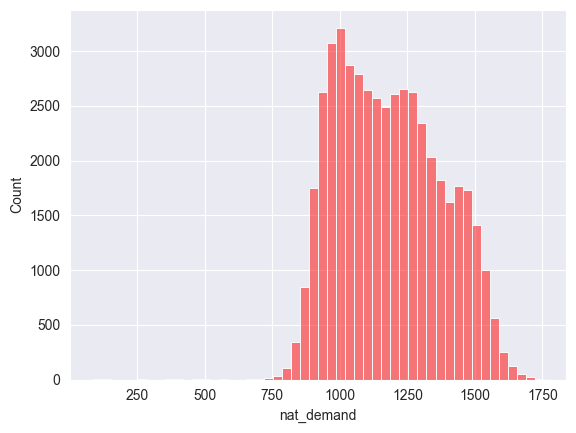

In [20]:
sns.histplot(df.nat_demand, color='red', bins=50, alpha=0.5)

<AxesSubplot: xlabel='nat_demand', ylabel='Count'>

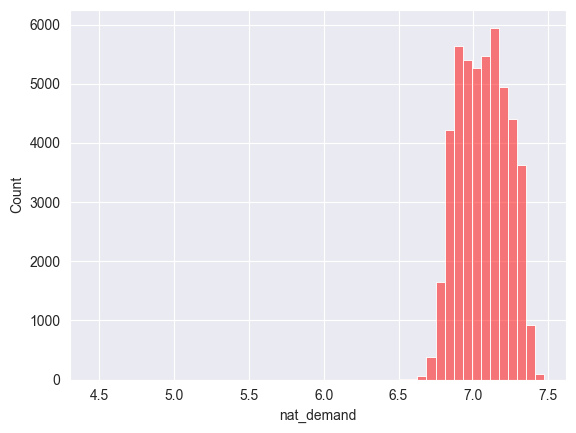

In [21]:
# See the distribution of the log1p version of the target variable
sns.histplot(np.log1p(df.nat_demand), color='red', bins=50, alpha=0.5)

<AxesSubplot: xlabel='nat_demand', ylabel='Count'>

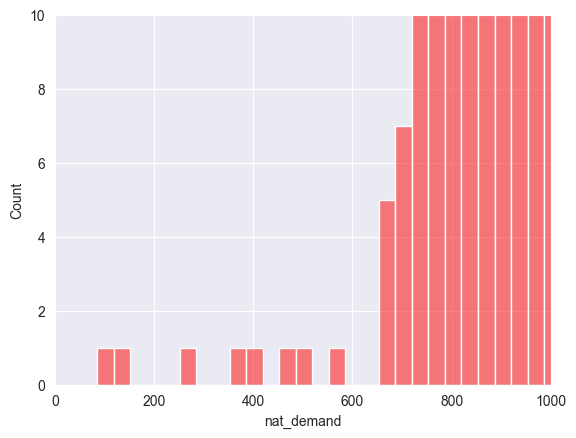

In [22]:
# Focusing on the long tail on the left. They seem to be outliers.
plt.xlim(0, 1000)
plt.ylim(0, 10)
sns.histplot(df.nat_demand, color='red', bins=50, alpha=0.5)

In [23]:
# Looks like there are 8 very low demands. This is only a 0.017% of the total records.
# Without these outliers the national demand values are 'normally' distributed.
# Therefore, no need to log1p() the values.
round(df.nat_demand[df.nat_demand < 600].size / len(df.nat_demand) * 100, 3)

0.017

<AxesSubplot: xlabel='nat_demand', ylabel='Count'>

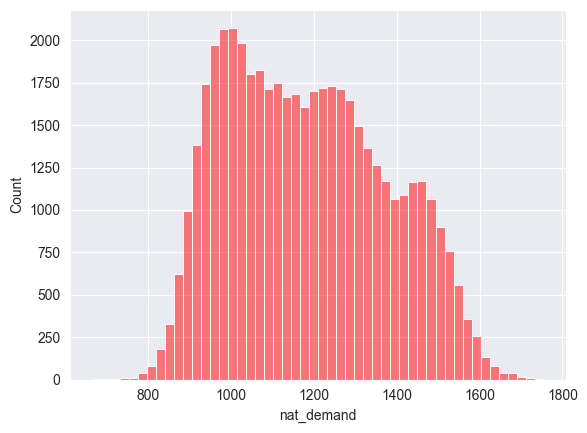

In [24]:
sns.histplot(df.nat_demand[df.nat_demand > 600], color='red', bins=50, alpha=0.5)

In [25]:
# Splitting the dataset to 80%, 20%, 20% for training, validation, and testing, respectively.

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
print(f'train:val:test split is {(len(df_train), len(df_val), len(df_test))}')

train:val:test split is (28828, 9610, 9610)


In [26]:
# Resetting indices
df_full_train.reset_index(inplace=True)
df_train.reset_index(inplace=True)
df_val.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [27]:
y_train = df_train.nat_demand
y_val = df_val.nat_demand
y_test = df_test.nat_demand

# log1p
# y_train = np.log1p(df_train.nat_demand)
# y_val = np.log1p(df_val.nat_demand)
# y_test = np.log1p(df_test.nat_demand)

In [28]:
# Removing unwanted variables
for c in ['nat_demand', 'dt', 'index']:
    del df_train[c]
    del df_val[c]
    del df_test[c]

In [29]:
y_test

0       1249.3280
1       1092.3660
2       1391.8517
3       1024.2945
4        945.4849
          ...    
9605    1322.9521
9606    1161.2246
9607    1204.8536
9608    1152.1953
9609    1013.1563
Name: nat_demand, Length: 9610, dtype: float64

In [30]:
# Vectorize the features
dv = DictVectorizer(sparse=False)
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

# Random Forest

Training a Random Forest Regressor by tuning 3 of its parameters, viz. n_estimators, max_depth and min_sample_leaf, to derive the best (lowest) RMSE score. The resulting RMSE will be set as the baseline. Once the baseline is set, an XGBoost Regressor will be trained and evaluated to see if we can achieve a model with a better RMSE.

In [31]:
rf = RandomForestRegressor(n_estimators=10,
                           random_state=1,
                           n_jobs=1,
                           max_depth=20)
model = rf.fit(X_train, y_train)
y_val_pred = rf.predict(X_val)

In [32]:
rf_performance = [('rmse', np.sqrt(mean_squared_error(y_val, y_val_pred))),
                  ('mae', mean_absolute_error(y_val, y_val_pred))]
pd.DataFrame(rf_performance, columns=['metric', 'score'])

,metric,score
0,rmse,82.903189
1,mae,56.510605


### Tune n_estimators

In [55]:
# Finding the optimal max_depth and n_estimators
scores = []
for d in tqdm([20, 25, 30, 35, 40, 45, 50]):
    for n in tqdm(range(10, 201, 20)):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=2)
        rf.fit(X_train, y_train)
        y_val_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        mae = mean_absolute_error(y_val, y_val_pred)
        scores.append((n, d, rmse, mae))

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [56]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'max_depth', 'rmse', 'mae'])
df_scores

,n_estimators,max_depth,rmse,mae
0,10,20,82.903189,56.510605
1,30,20,80.207970,54.963877
2,50,20,79.308285,54.569571
3,70,20,78.950624,54.328043
4,90,20,78.957290,54.380347
...,...,...,...,...
65,110,50,77.975645,53.772770
66,130,50,77.949263,53.761991
67,150,50,77.830471,53.708756
68,170,50,77.848341,53.707541


  0%|          | 0/7 [00:00<?, ?it/s]

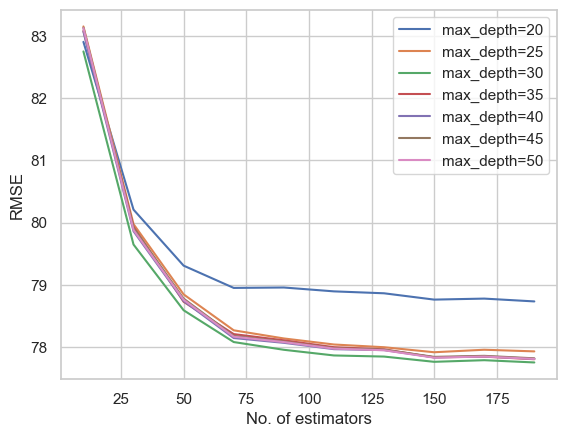

In [58]:
# plt.figure(figsize=(8, 6))
plt.xlabel('No. of estimators')
plt.ylabel('RMSE')
for d in tqdm([20, 25, 30, 35, 40, 45, 50]):
    plt.plot(df_scores[df_scores.max_depth == d].n_estimators,
             df_scores[df_scores.max_depth == d].rmse,
             label=f'max_depth={d}')
plt.legend()

# XGBoost

In [ ]:
features = dv.get_feature_names_out()
dm_train = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dm_val = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [ ]:
def train_gb_model(eta=0.3, max_depth=6, min_child_weight=1, num_boost_round=200):
    watchlist = [(dm_train, 'train'), (dm_val, 'val')]
    xgb_params = {
        'eta': eta,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,

        'eval_metric': 'rmse',
        'objective': 'reg:squarederror',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1
    }
    evals_result = {}
    xgb.train(params=xgb_params,
              dtrain=dm_train,
              num_boost_round=num_boost_round,
              # verbose_eval=5,
              evals=watchlist,
              evals_result=evals_result)

    columns = ['eta', 'iter', 'train_rmse', 'val_rmse']
    train_rmse_scores = list(evals_result['train'].values())[0]
    val_rmse_scores = list(evals_result['val'].values())[0]

    df_scores = pd.DataFrame(
        list(zip([eta] * len(train_rmse_scores),
                 range(1, len(train_rmse_scores) + 1),
                 train_rmse_scores,
                 val_rmse_scores
                 )), columns=columns)
    return df_scores

In [ ]:
scores = {}
for eta in tqdm([0.3, 1.0, 0.1, 0.05, 0.01]):
    key = f'eta={eta}'
    df_scores = train_gb_model(eta=eta)
    scores[key] = df_scores

In [ ]:
plt.figure(figsize=(14, 10))
for key, df_scores in scores.items():
    plt.plot(df_scores.iter, df_scores.val_rmse, label=key)
    plt.legend()

In [ ]:
plt.figure(figsize=(14, 10))
for key, df_scores in scores.items():
    plt.plot(df_scores.iter, df_scores.train_rmse, label=key)
    plt.legend()

<AxesSubplot: >

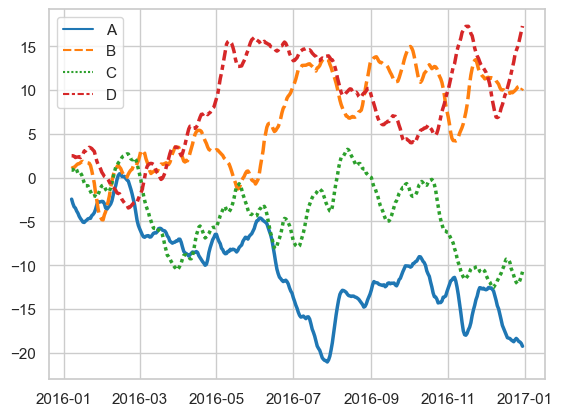

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

rs = np.random.RandomState(365)
values = rs.randn(365, 4).cumsum(axis=0)
dates = pd.date_range("1 1 2016", periods=365, freq="D")
data = pd.DataFrame(values, dates, columns=["A", "B", "C", "D"])
data = data.rolling(7).mean()

sns.lineplot(data=data, palette="tab10", linewidth=2.5)